In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import sys
sys.path.append("..")  # if simulator.ipynb is in /notebooks/

import pickle

from simulation.helpers import create_circular_roads
from simulation.core import System
from simulation.controller import TrafficController
from simulation.data_logger import DataLogger
from simulation.spawners import timed_spawner
from simulation.core import Road


In [ ]:
dt = 0.01
sim_time = 30

system = System(dt=dt, final_time=sim_time)

start_pos = (100, 300)
end_pos = (700, 300)
road = Road(num_lanes=1, max_speed=200, start_pos=start_pos, end_pos=end_pos, lane_width=30)

system.add_road(road)

logger = DataLogger(tag="basic_one_road_test")
controller = TrafficController(system, logger=logger)

controller.add_spawn_rule(timed_spawner(interval=1.5, road_index=0))

In [29]:
# Run loop
for _ in range(int(system.final_time / system.dt)):
    controller.control(system.dt)
    system.update(logger=logger)

# Analyze exits
exit_df = logger.to_exit_dataframe()
display(exit_df.head())
print(f"Cars exited: {len(exit_df)}")

,car_id,exit_time,last_offset,last_velocity
0,2582723796272,10.69,0,120.4
1,2582761202912,12.19,0,120.4
2,2582761200944,13.69,0,120.4
3,2582761203104,15.19,0,120.4
4,2582761201952,16.69,0,120.4


Cars exited: 13


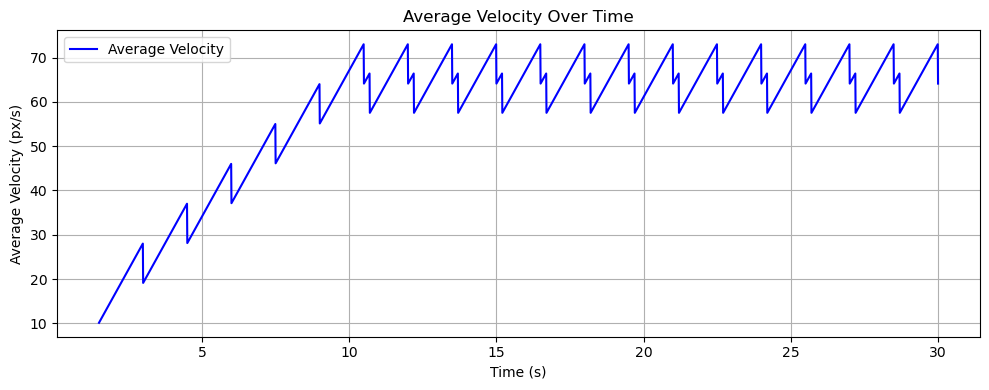

In [31]:
import matplotlib.pyplot as plt

# Get the full log data
df = logger.to_dataframe()

# Group by time and compute average velocity
avg_velocity_by_time = df.groupby("time")["velocity"].mean()

# Plot
plt.figure(figsize=(10, 4))
plt.plot(avg_velocity_by_time.index, avg_velocity_by_time.values, label="Average Velocity", color='blue')
plt.xlabel("Time (s)")
plt.ylabel("Average Velocity (px/s)")
plt.title("Average Velocity Over Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
